In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cv2
from skimage import io
import os
import random
import copy

# Tumor diagnosis

In [9]:
def gray_image_func(image):

    gray_image = np.zeros_like(image)
    gray_image = 0.2989 * image[:, :, 2] + 0.5870 * image[:, :, 1] + 0.1140 * image[:, :, 0]
    gray_image = np.uint8(gray_image)
    
    return gray_image   


def binary_image_func(image , threshold):    
    
    binary_image = np.zeros_like(image)
    image_length = []
    
    for i in range (3):
        image_length.append(image.shape[i])

    for i in range(image_length[0]):  
        for j in range(image_length[1]): 
            RGB_average = np.mean(image[i, j])  
    
            if RGB_average > threshold:
                binary_image[i, j] = 255
            else:
                binary_image[i, j] = 0 
                
    binary_image =  1* binary_image[:, :, 0]        
                         
    return binary_image
    


def histogram_binary(image):
    
    histogram = np.zeros(2, dtype=int)
    
    histogram[0] = np.sum(image == 0)
    histogram[1] = np.sum(image == 255)
    
    return histogram


def template_matching (image , imagee , th1 , th2):
    image1 = binary_image_func(image , th1)
    image2 = binary_image_func(imagee , th2)

    image1 = (image1 / 255).astype(np.uint8)
    image2 = (image2 / 255).astype(np.uint8)

    intersection = np.logical_and(image1, image2).sum()
    union = np.logical_or(image1, image2).sum()
    #union = 255
    jaccard_index = intersection / union if union != 0 else 0

    dice_coefficient = (2 * intersection) / (image1.sum() + image2.sum()) if (image1.sum() + image2.sum()) != 0 else 0

    return print("Jaccard Index (IoU):", jaccard_index) , print("Dice Coefficient:", dice_coefficient)



In [10]:
image = cv2.imread('Part5/1.jpeg')
image.shape


(512, 512, 3)

In [11]:
def tumor_diagnosis (image , threshold , d_th , min_area):
    
    image = cv2.imread(image)

    binary_brain = binary_image_func(image , threshold)

    height, width = binary_brain.shape
    
    midpoint = width // 2

    left_part = binary_brain[:, :midpoint]
    right_part = binary_brain[:, midpoint:]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')

    plt.subplot(1, 4, 2)
    plt.title("Left Part")
    plt.imshow(left_part, cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title("Right Part")
    plt.imshow(right_part, cmap='gray')

    plt.tight_layout()
    plt.show()
    
    hist1 = histogram_binary(right_part)
    hist2 = histogram_binary(left_part)
    
    #diagnosis = np.abs(hist1 - hist2)
    #if diagnosis[1] > d_th
    #....
    
    diagnosis = np.abs(np.flip(right_part, 1) - left_part)
   
    tumor_detected = False
    contours, _ = cv2.findContours(diagnosis, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if  area > min_area:
            tumor_detected = True

    if tumor_detected:
        print ('A tumor is diagnosed')
    else:
        print('There is no tumor to diagnosed')

    #plt.title("Right Part")
    #plt.imshow(diagnosis, cmap='gray')
    return

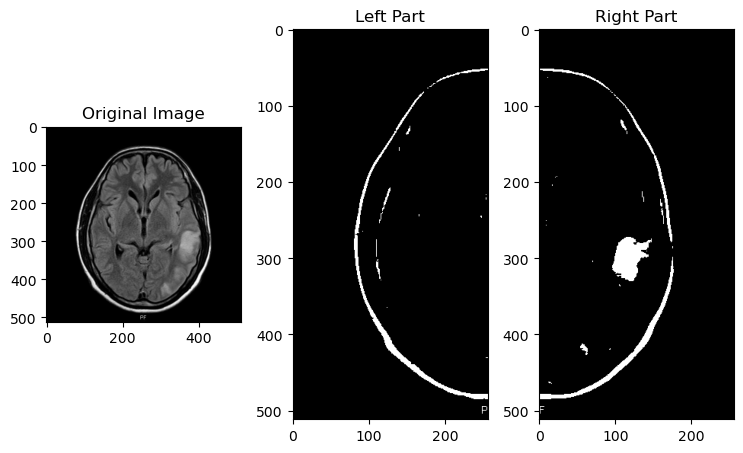

A tumor is diagnosed


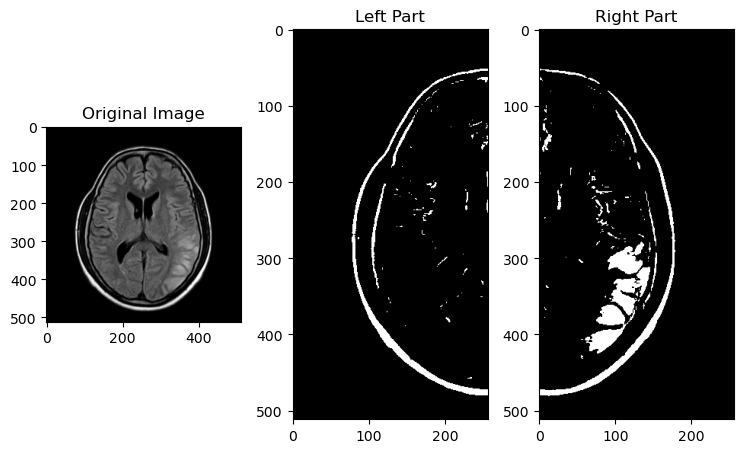

A tumor is diagnosed


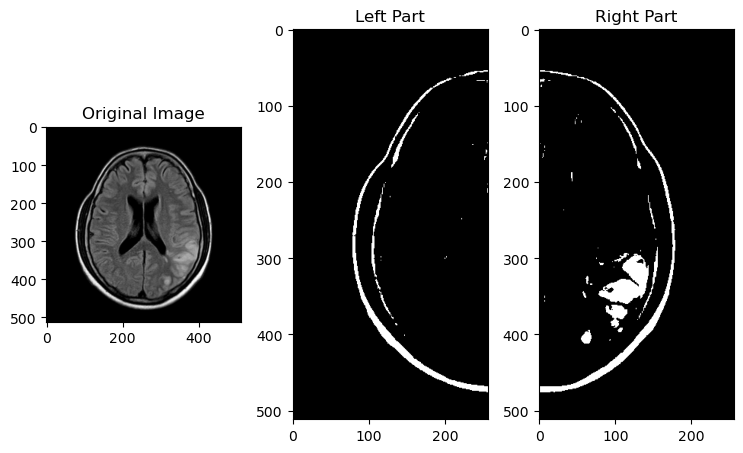

A tumor is diagnosed


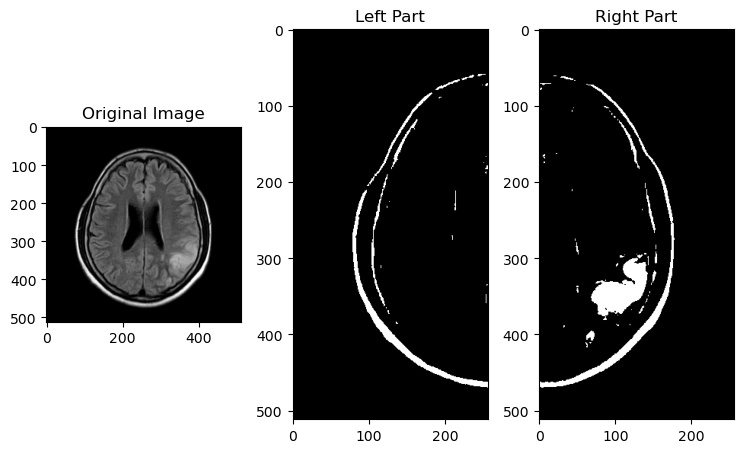

A tumor is diagnosed


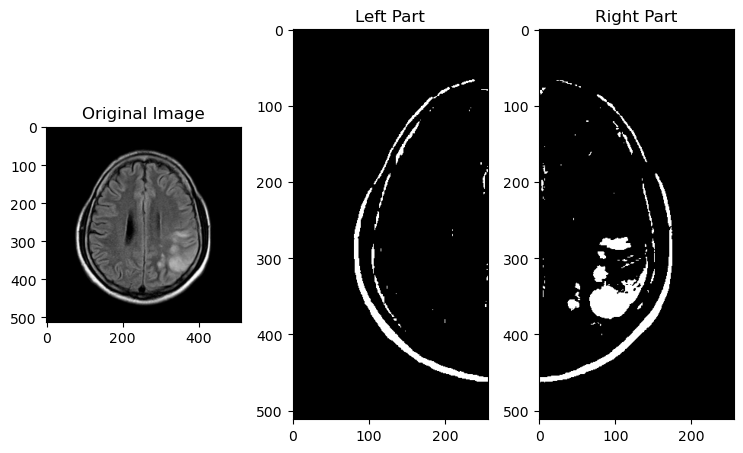

A tumor is diagnosed


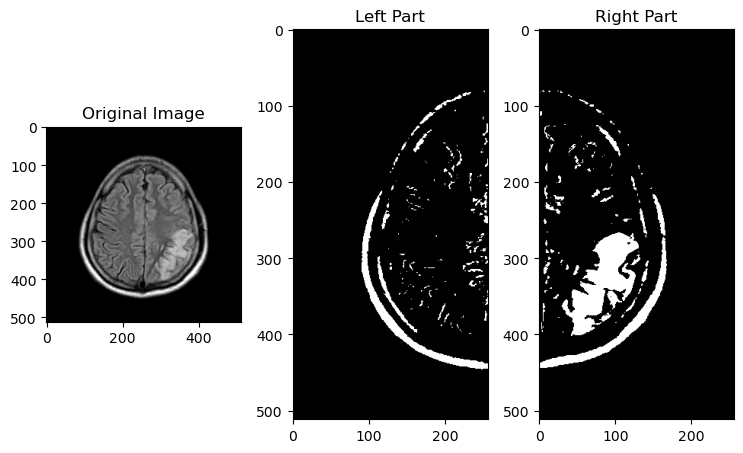

A tumor is diagnosed


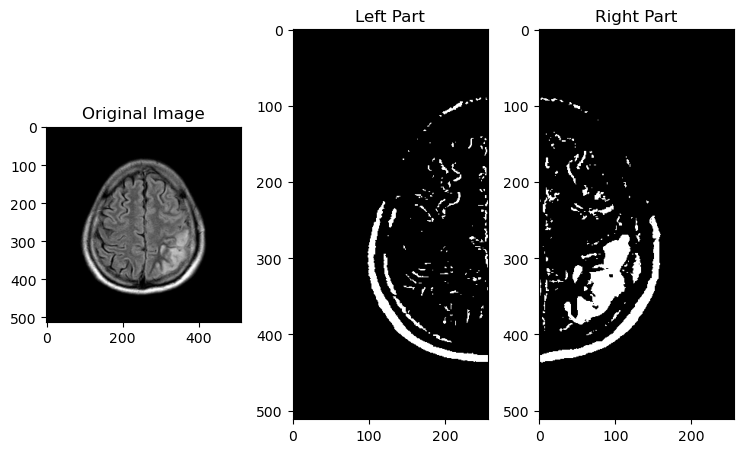

A tumor is diagnosed


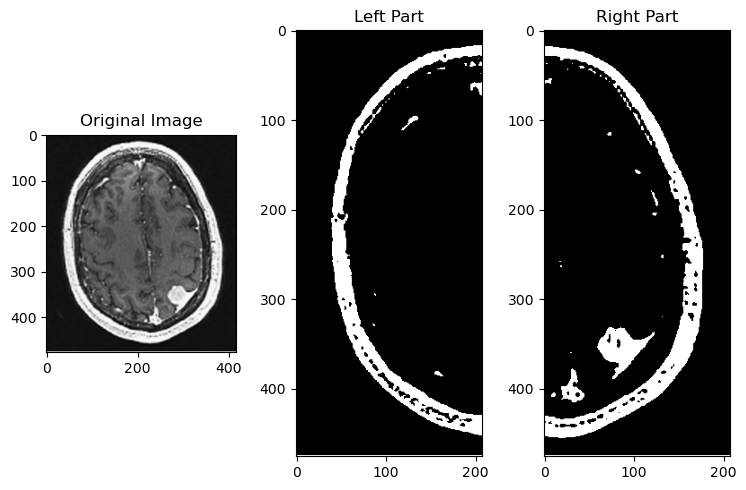

A tumor is diagnosed


In [12]:
image_parameters = [
    {"filename": "Part5/1.jpeg", "binary_threshold": 140, "diagnosed_threshold": 500 , "min_area" : 1500},
    {"filename": "Part5/2.jpeg", "binary_threshold": 120, "diagnosed_threshold": 500 , "min_area" : 2500},
    {"filename": "Part5/3.jpeg", "binary_threshold": 130, "diagnosed_threshold": 500 , "min_area" : 2000},
    {"filename": "Part5/4.jpeg", "binary_threshold": 130, "diagnosed_threshold": 500 , "min_area" : 2500},
    {"filename": "Part5/5.jpeg", "binary_threshold": 130, "diagnosed_threshold": 500 , "min_area" : 2250},
    {"filename": "Part5/6.jpeg", "binary_threshold": 130, "diagnosed_threshold": 500 , "min_area" : 2000},
    {"filename": "Part5/7.jpeg", "binary_threshold": 130, "diagnosed_threshold": 500 , "min_area" : 2250},
    {"filename": "Part5/8.jpg" , "binary_threshold": 200, "diagnosed_threshold": 500 , "min_area" : 1500},
]

#tumor_diagnosis("Part5/1.jpeg" , 160 , 500)

for i in range (8):
    inputt = image_parameters[i]["filename"]
    binaryy_threshold = image_parameters[i]["binary_threshold"]
    diagnosedd_threshold = image_parameters[i]["diagnosed_threshold"]
    min_areaa = image_parameters[i]["min_area"]
    tumor_diagnosis(inputt , binaryy_threshold , diagnosedd_threshold , min_areaa)


# Segmenting tumor

In [13]:
output  = 'Part5/output'

def segmenting_tumor(image , threshold_value , Blur_kernel , kernel_value , min_pixel , max_pixel):

    image = cv2.imread(image , cv2.IMREAD_GRAYSCALE)

    blurred_image = cv2.GaussianBlur(image, (Blur_kernel, Blur_kernel), 0)
                                     
    _, binary_image = cv2.threshold(blurred_image, threshold_value, 255, cv2.THRESH_BINARY)

    kernel = np.ones((kernel_value, kernel_value), np.uint8)
    cleaned_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel, iterations=2)

    contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour) 
        
        if min_pixel < area < max_pixel and x > image.shape[1] / 2:  
            cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 2)  
            

    plt.figure(figsize=(10 , 10))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title("Tumor")
    plt.axis('off')

    plt.show()

    return output_image



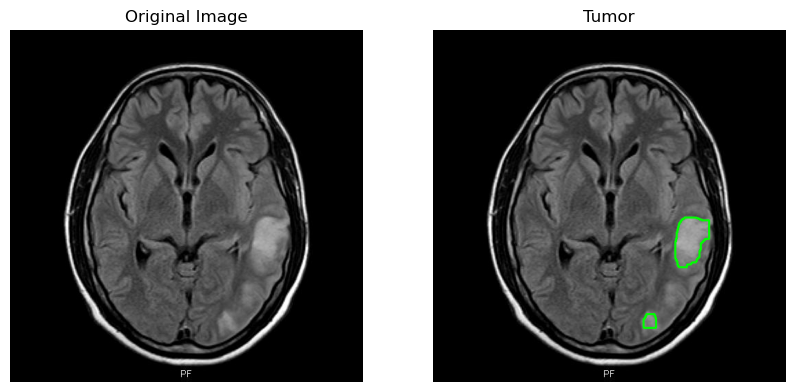

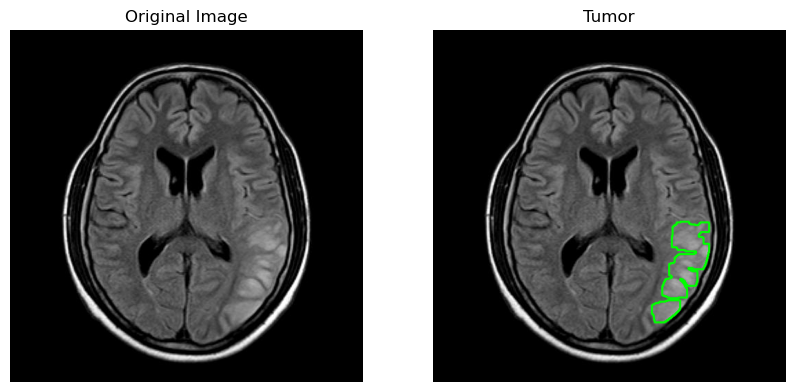

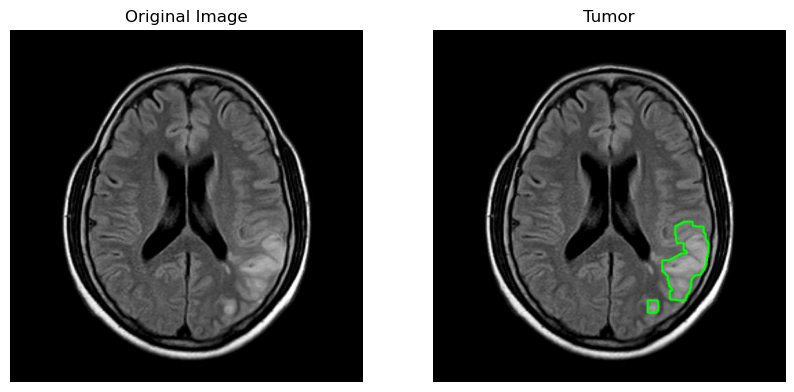

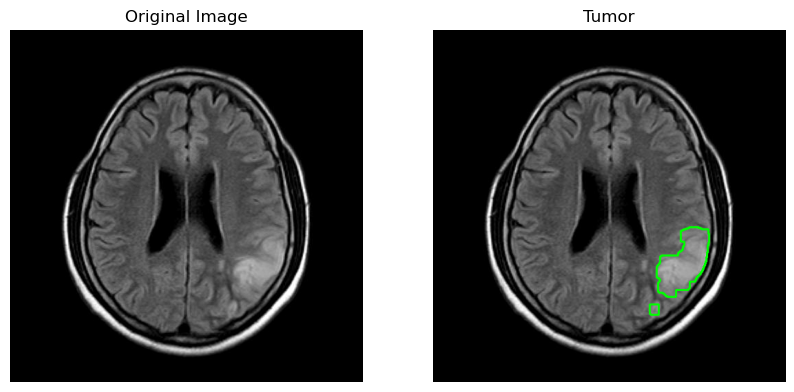

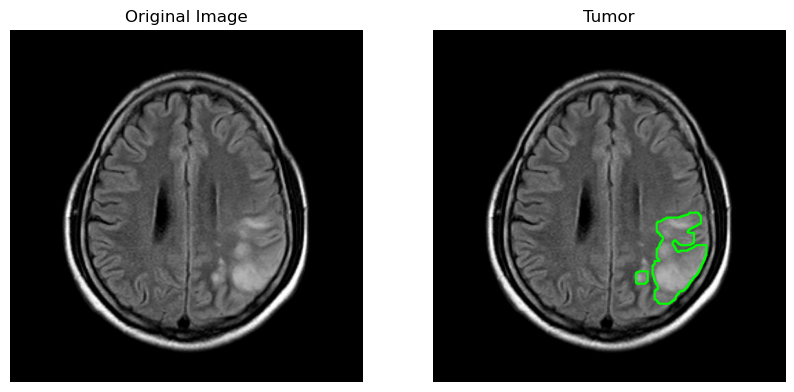

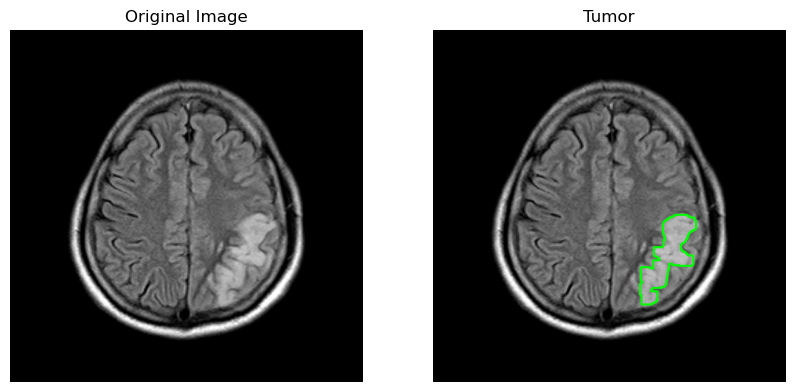

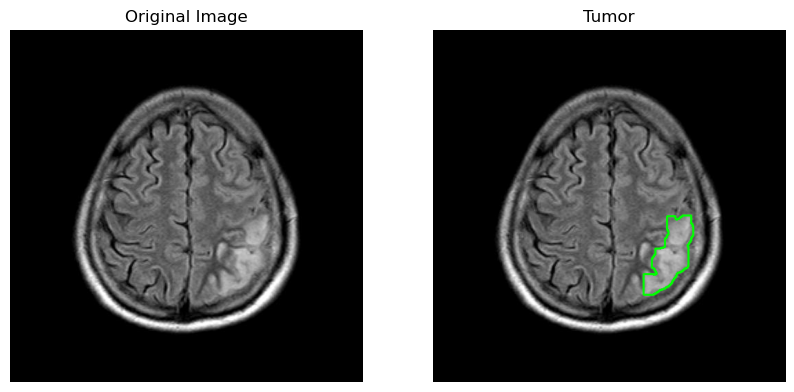

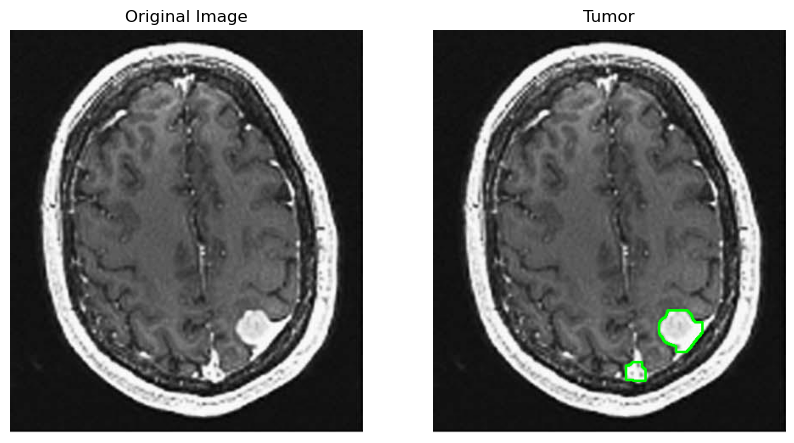

Done


In [14]:
def image_segment(input_image , output , threshold_value , Blur_threshold , kernel_value , min_pixel , max_pixel):
    
    tumor_segmented = segmenting_tumor(input_image, threshold_value , Blur_threshold , kernel_value , min_pixel , max_pixel)
    filename = os.path.basename(input_image)
    output_path = os.path.join(output, filename)
    cv2.imwrite(output_path, tumor_segmented)
    
    return

image_parameters = [
    {"filename": "Part5/1.jpeg", "threshold_value": 110, "Blur_threshold": 7, "kernel_value": 7, "min_pixel": 300, "max_pixel": 10000},
    {"filename": "Part5/2.jpeg", "threshold_value": 105, "Blur_threshold": 7, "kernel_value": 7, "min_pixel": 500, "max_pixel": 10000},
    {"filename": "Part5/3.jpeg", "threshold_value": 105, "Blur_threshold": 7, "kernel_value": 7, "min_pixel": 70, "max_pixel": 10000},
    {"filename": "Part5/4.jpeg", "threshold_value": 105, "Blur_threshold": 7, "kernel_value": 7, "min_pixel": 5, "max_pixel": 10000},
    {"filename": "Part5/5.jpeg", "threshold_value": 100, "Blur_threshold": 7, "kernel_value": 7, "min_pixel": 250, "max_pixel": 10000},
    {"filename": "Part5/6.jpeg", "threshold_value": 130, "Blur_threshold": 7, "kernel_value": 7, "min_pixel": 500, "max_pixel": 12000},
    {"filename": "Part5/7.jpeg", "threshold_value": 110, "Blur_threshold": 7, "kernel_value": 7, "min_pixel": 500, "max_pixel": 10000},
    {"filename": "Part5/8.jpg" , "threshold_value": 110, "Blur_threshold": 7, "kernel_value": 7, "min_pixel": 300, "max_pixel": 10000},
]

#image_parameters[1]["param1"]

for i in range (8):
    inputt = image_parameters[i]["filename"]
    threshold_valuee = image_parameters[i]["threshold_value"]
    Blur_thresholdd = image_parameters[i]["Blur_threshold"]
    kernel_valuee = image_parameters[i]["kernel_value"]
    min_pixell = image_parameters[i]["min_pixel"]
    max_pixell = image_parameters[i]["max_pixel"]
    image_segment(inputt , output , threshold_valuee , Blur_thresholdd , kernel_valuee , min_pixell , max_pixell)

print("Done")    

#image_parameters[1]["filename"]